# A Stock and Flow Model For The Beer Distribution Game

The Beer Game was originally developed in the late 1950s by Jay Forrester at MIT to introduce the concepts of dynamical systems. The beer game is fascinating at many levels:

* It illustrates how difficult it is to manage dynamic systems, even if you think you understand them. And especially when you don't have control of all variables in the system.
* It is a wonderful illustration of scientific thinking - reducing a complex reality to a conceptually much simpler model and then using that model to reason about reality.
* It is a great object of study to see how computational modeling can help to understand complex systems - this repository contains models created using System Dynamics and Agent-based modeling.
* It is also a useful testbed to see how machine learning techniques such as reinforcement learning can be used to train agents to play the beer game autonomously.

While the notebook [Understanding the Beergame](understanding_the_beergame.ipynb) analyses playing strategies in detail using a simulation model built using System Dynamics, it doesn't actually explain the underlying Stock and Flow model itself. This notebook fills that gap.


If you have never played the beergame, you might like to try it before you read this post. 

In [1]:
from IPython.display import IFrame       
IFrame('https://beergame.transentis.com',width="700",height="500")

P.S: If you prefer to play the game in a separate screen try [beergame.transentis.com](http://beergame.transentis.com)

## The Challenge: Managing The Supply Chain

To understand the challenge of managing a supply chain, let’s take a more detailed look at its structure – the supply chain leads from the brewery, via a distributor and wholesaler to the reseller, who sells beer to his customers, the end consumers.

The objective of the game is to ensure that the consumers demand for beer can be met directly or at least with as small a delay as possible, while keeping each players inventory as small as possible.

The sketch below illustrates the supply chain and the flow of information along it:

![Overview of the supply chain](images/supply_chain.png)

Initially customer demand for beer is stable at 100 units per week and the entire supply chain is in a steady state. Each member of the supply chain has an inventory of 400 units.

The rules of the game are simple – in every round each player performs the following four steps:

* __Check deliveries.__ Check how many units of beer are being delivered to him from his supplier in the supply chain
* __Check incoming orders.__ Check how many units of beer his client in the supply chain has ordered.
* __Deliver beer.__ Deliver as much beer as he can to satisfy the customers demand (Note: in our implementation of the game above, this step is performed for you automatically).
* __Place outgoing order__. The difficult step is to decide how many units of beer the player needs from his supplier to keep his inventory stocked up and to ensure he has enough beer to meet future demands.

> Note: In the single player version of the game that I included above, you play the role of the retailer. The other roles are played by the computer, i.e. the order decision for these players is made by the computer according to a predefined order policy (the order policy the computer follows is essentially the one developed in this blog post).

## Build a Stock and Flow Model

Whenever I start building a simulation model, the first thing I to understand what parts the model will have at the top level.

The key insight when build a stock and flow model for the Beer Game is that the brewery, the distributor, the wholesaler and the retailer are actually governed by the same dynamics - with one small exception: the brewery doesn't order beer from a supplier but produces the beer itself.

The whole point of having a simulation model is that we want to monitor the performance of each of the players and the supply chain itself. For that reason it makes sense to extract the monitoring of the supply chain into a separate part of the model. 

In [2]:
from BPTK_Py.config import matplotlib_rc_settings

configuration = {"matplotlib_rc_settings" :matplotlib_rc_settings}

configuration["matplotlib_rc_settings"]["font.family"]="Marydale, DejaVu Sans"

In [3]:
from BPTK_Py import bptk
bptk = bptk(configuration=configuration)

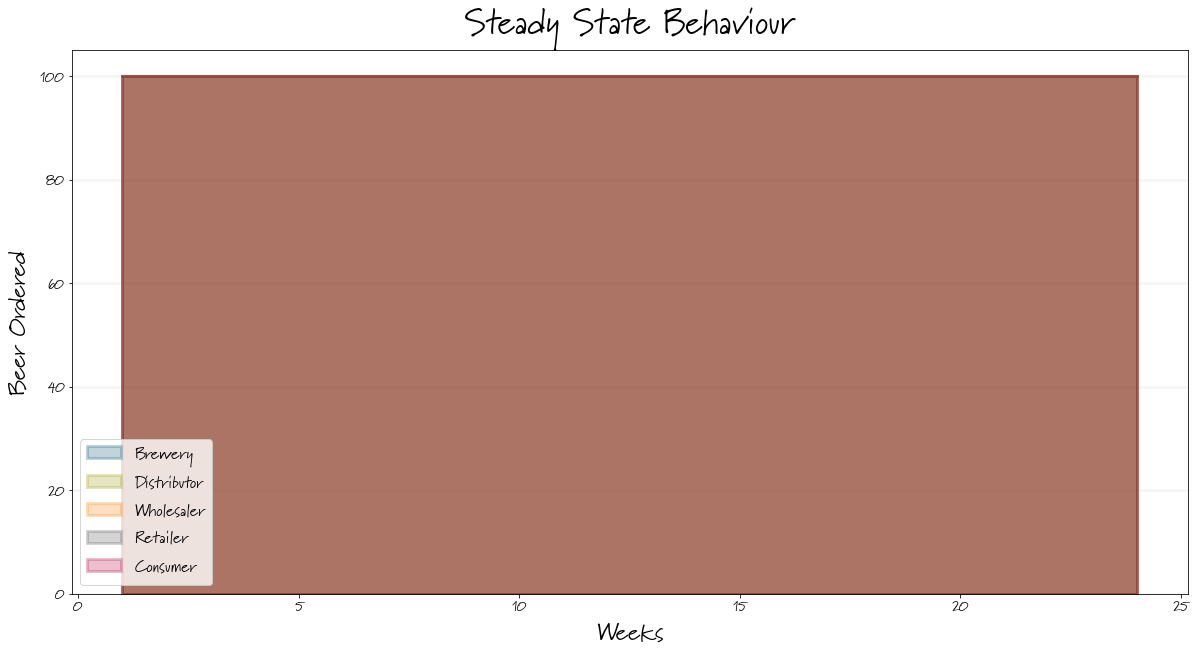

In [4]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["steady_state"],
    title="Steady State Behaviour",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders","consumer.sending_orders"],
    series_names={
        "brewery.sending_orders" : "Brewery",
        "distributor.sending_orders" : "Distributor",
        "wholesaler.sending_orders": "Wholesaler",
        "retailer.sending_orders": "Retailer",
        "consumer.sending_orders": "Consumer"
    }
)

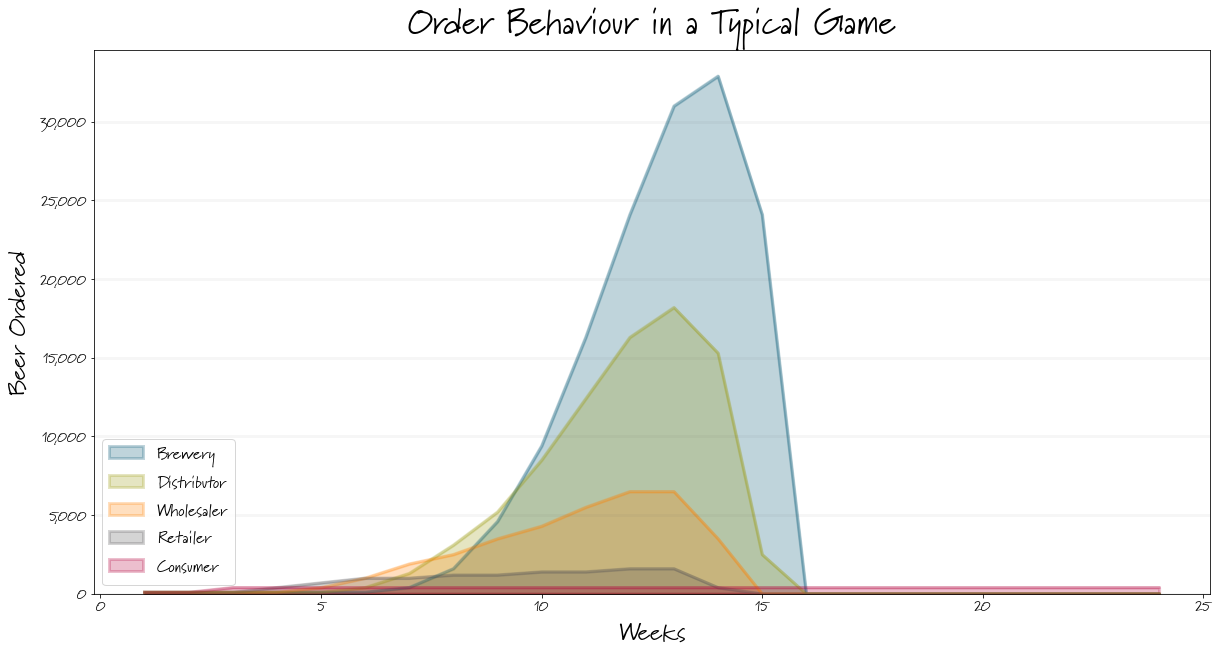

In [5]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["typical"],
    title="Order Behaviour in a Typical Game",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders", "consumer.sending_orders"],
    series_names={
        "sd_dsl_beergame_typical_brewery.sending_orders" : "Brewery",
        "sd_dsl_beergame_typical_distributor.sending_orders" : "Distributor",
        "sd_dsl_beergame_typical_wholesaler.sending_orders": "Wholesaler",
        "sd_dsl_beergame_typical_retailer.sending_orders": "Retailer",
        "sd_dsl_beergame_typical_consumer.sending_orders": "Consumer"
    }
)

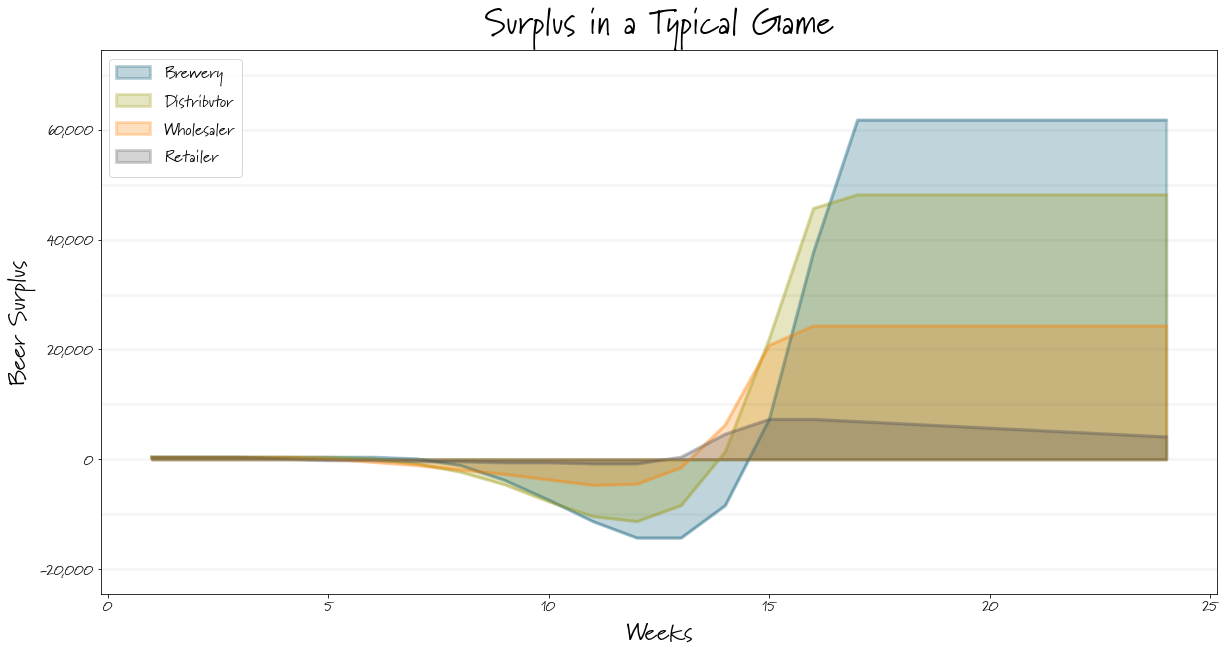

In [6]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["typical"],
    title="Surplus in a Typical Game",
    x_label="Weeks",
    y_label="Beer Surplus",
    equations=["brewery.surplus","distributor.surplus","wholesaler.surplus","retailer.surplus"],
    series_names={
        "brewery.surplus" : "Brewery",
        "distributor.surplus" : "Distributor",
        "wholesaler.surplus": "Wholesaler",
        "retailer.surplus": "Retailer"
    }
)

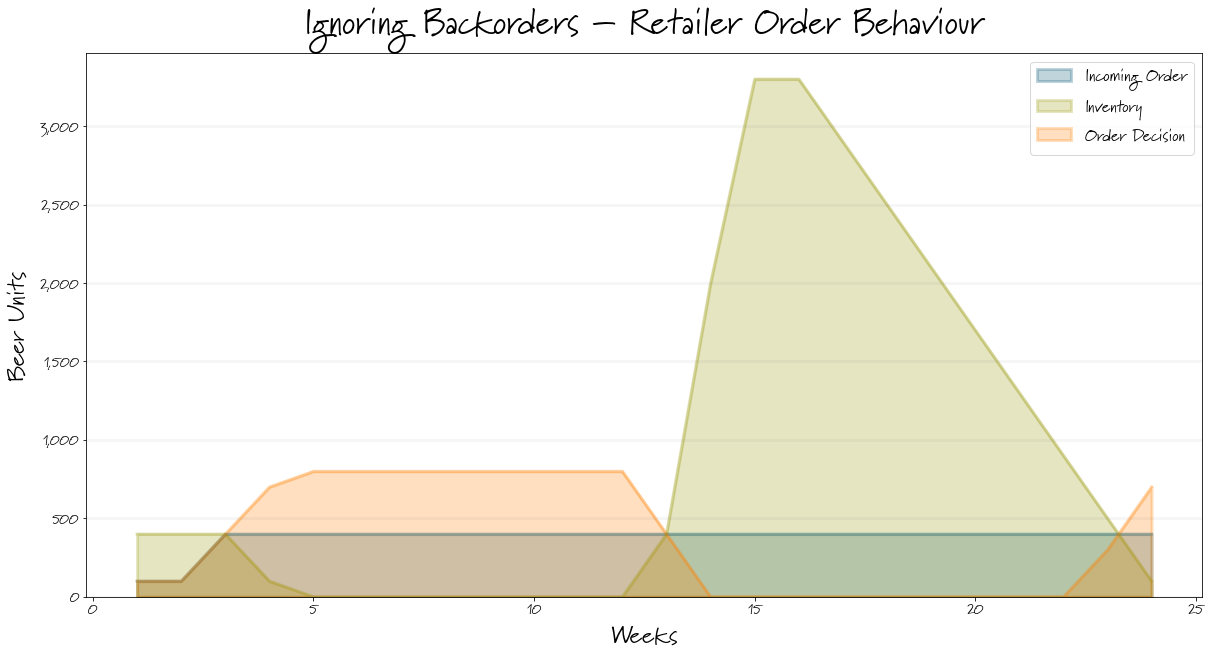

In [7]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["ignore_backorders"],
    title="Ignoring Backorders – Retailer Order Behaviour",
    x_label="Weeks",
    y_label="Beer Units",
    equations=["retailer.incoming_orders","retailer.inventory","retailer.order_decision"],
    series_names={
        "sd_dsl_beergame_ignore_backorders_retailer.incoming_orders" : "Incoming Order",
        "sd_dsl_beergame_ignore_backorders_retailer.inventory": "Inventory",
        "sd_dsl_beergame_ignore_backorders_retailer.order_decision": "Order Decision"
    }
    
)

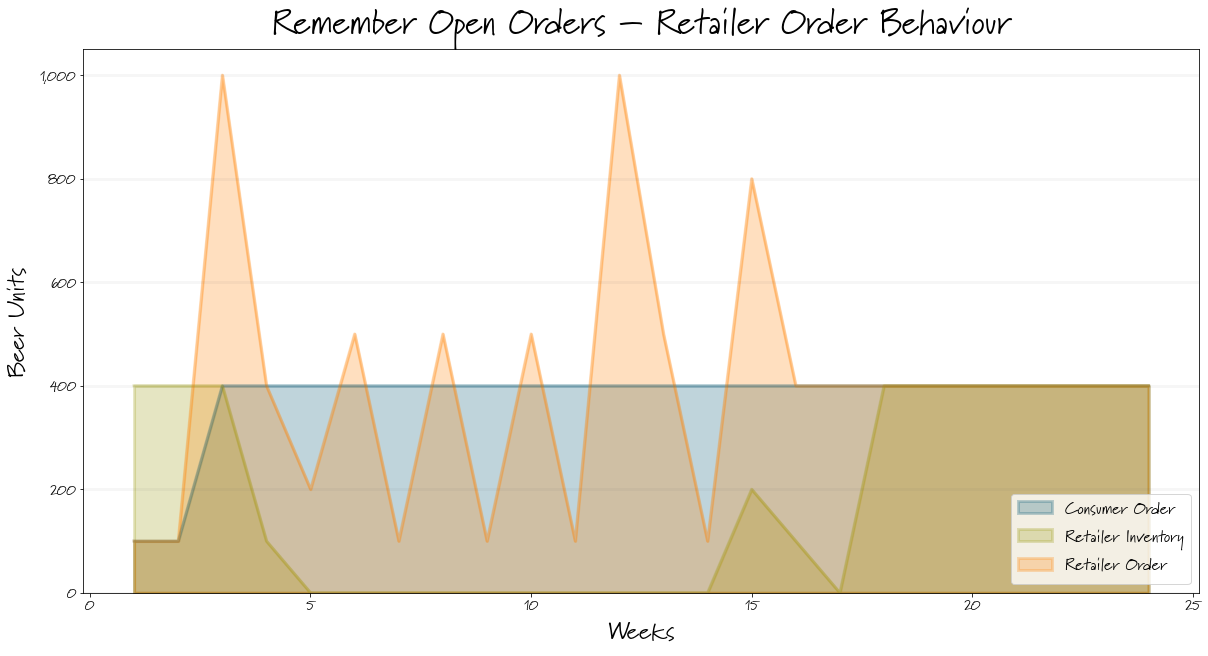

In [8]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["include_supply_line"],
    title="Remember Open Orders – Retailer Order Behaviour",
    x_label="Weeks",
    y_label="Beer Units",
    equations=["retailer.incoming_orders","retailer.inventory","retailer.order_decision"],
    series_names={
        "sd_dsl_beergame_include_supply_line_retailer.incoming_orders" : "Consumer Order",
        "sd_dsl_beergame_include_supply_line_retailer.inventory": "Retailer Inventory",
        "sd_dsl_beergame_include_supply_line_retailer.order_decision": "Retailer Order",
        
    }
)

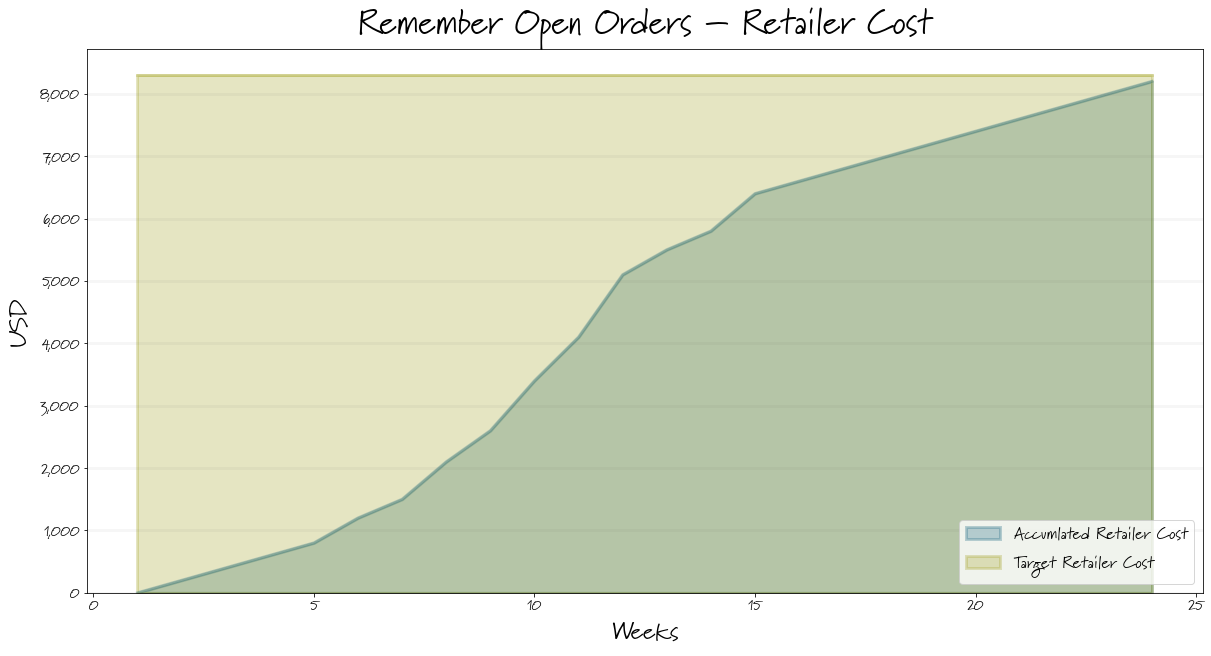

In [9]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["include_supply_line"],
    title="Remember Open Orders – Retailer Cost",
    x_label="Weeks",
    y_label="USD",
    equations=["performance_controlling.total_retailer_cost","policy_settings.target_retailer_cost"],
    series_names={
        "sd_dsl_beergame_include_supply_line_performance_controlling.total_retailer_cost" : "Accumlated Retailer Cost",
        "sd_dsl_beergame_include_supply_line_policy_settings.target_retailer_cost": "Target Retailer Cost"
    }
)

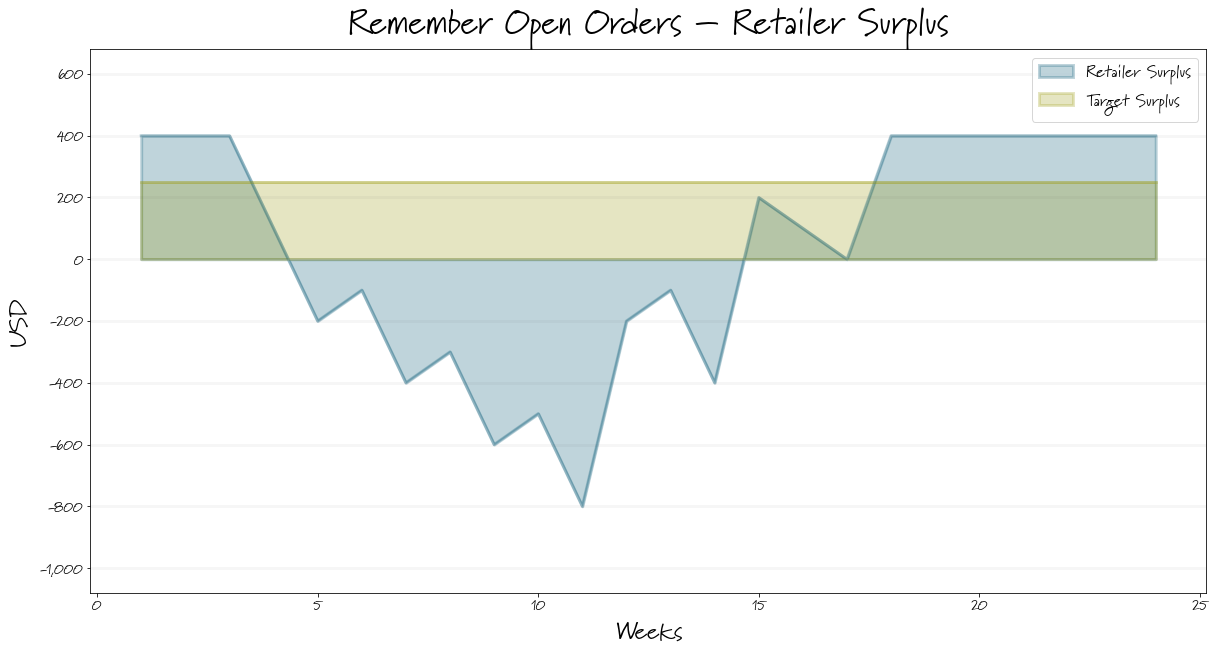

In [10]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["include_supply_line"],
    title="Remember Open Orders – Retailer Surplus",
    x_label="Weeks",
    y_label="USD",
    equations=["retailer.surplus","policy_settings.target_surplus"],
    series_names={
        "sd_dsl_beergame_include_supply_line_retailer.surplus" : "Retailer Surplus",
        "sd_dsl_beergame_include_supply_line_policy_settings.target_surplus": "Target Surplus"
    }
)

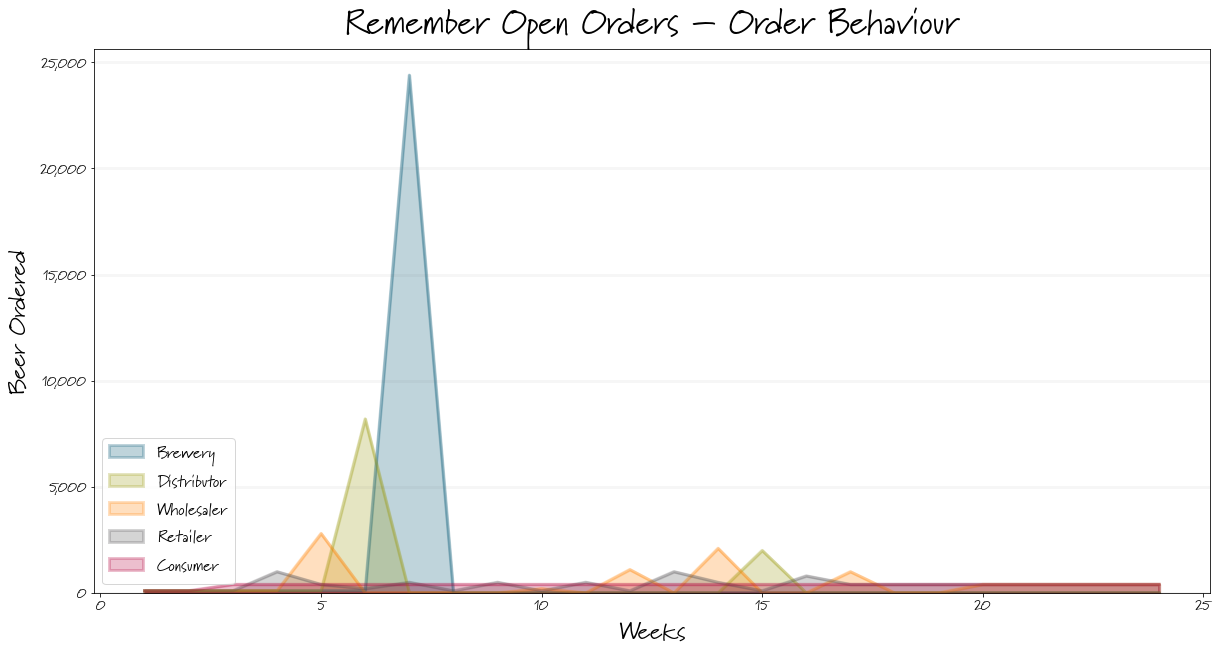

In [11]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["include_supply_line"],
    title="Remember Open Orders – Order Behaviour",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders", "consumer.sending_orders"],
    series_names={
        "sd_dsl_beergame_include_supply_line_brewery.sending_orders" : "Brewery",
        "sd_dsl_beergame_include_supply_line_distributor.sending_orders" : "Distributor",
        "sd_dsl_beergame_include_supply_line_wholesaler.sending_orders": "Wholesaler",
        "sd_dsl_beergame_include_supply_line_retailer.sending_orders": "Retailer",
        "sd_dsl_beergame_include_supply_line_consumer.sending_orders": "Consumer"
    }
)

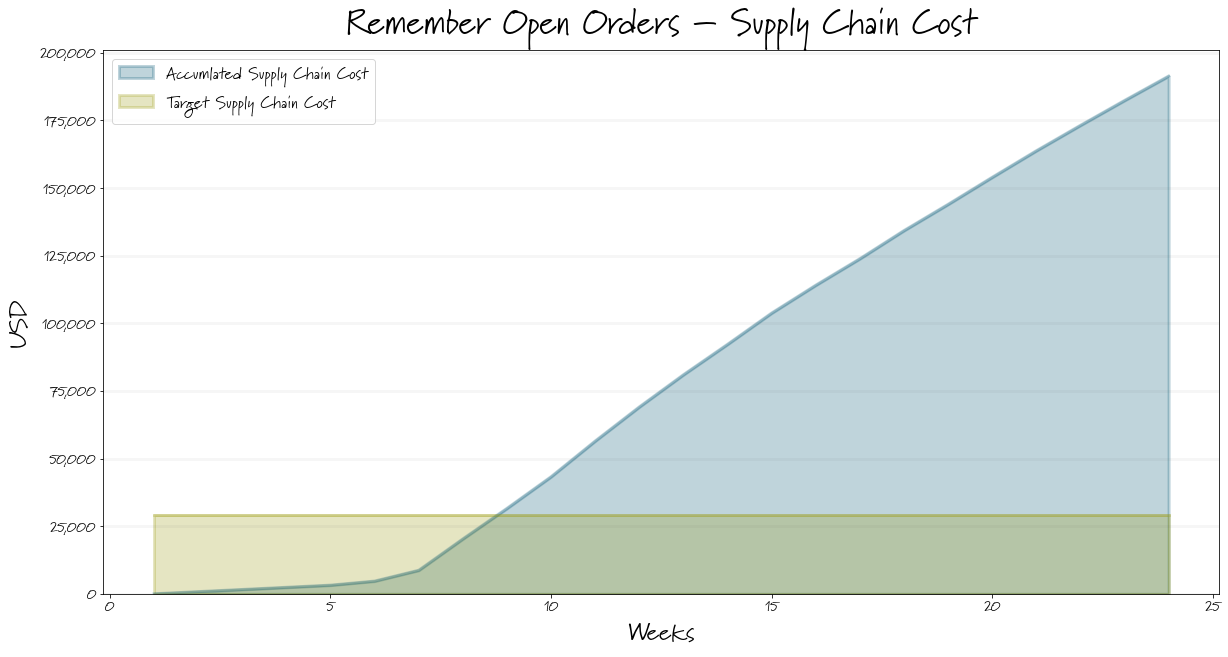

In [12]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["include_supply_line"],
    title="Remember Open Orders – Supply Chain Cost",
    x_label="Weeks",
    y_label="USD",
    equations=["performance_controlling.total_supply_chain_cost","policy_settings.target_supply_chain_cost"],
    series_names={
        "sd_dsl_beergame_include_supply_line_performance_controlling.total_supply_chain_cost" : "Accumlated Supply Chain Cost",
        "sd_dsl_beergame_include_supply_line_policy_settings.target_supply_chain_cost": "Target Supply Chain Cost"
    }
)

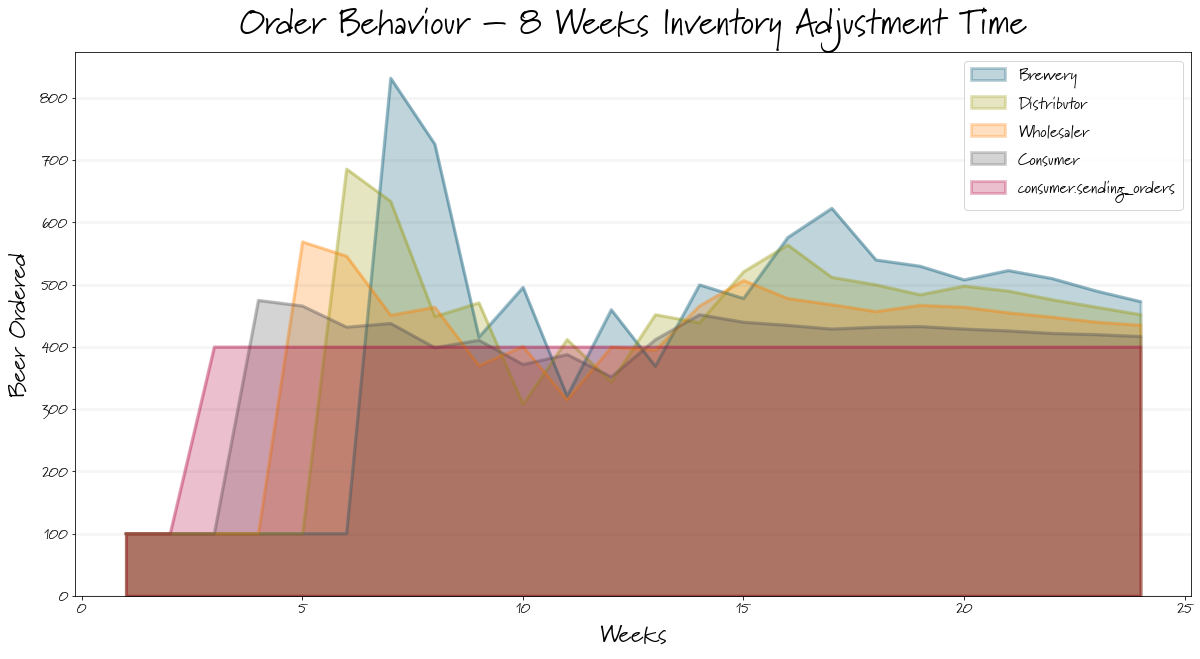

In [13]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["inventory_adjustment_time_8"],
    title="Order Behaviour – 8 Weeks Inventory Adjustment Time",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders", "consumer.sending_orders"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_8_brewery.sending_orders" : "Brewery",
        "sd_dsl_beergame_inventory_adjustment_time_8_distributor.sending_orders" : "Distributor",
        "sd_dsl_beergame_inventory_adjustment_time_8_wholesaler.sending_orders": "Wholesaler",
        "sd_dsl_beergame_inventory_adjustment_time_8_retailer.sending_orders": "Retailer",
        "sd_dsl_beergame_inventory_adjustment_time_8_retailer.sending_orders": "Consumer"
    }
)

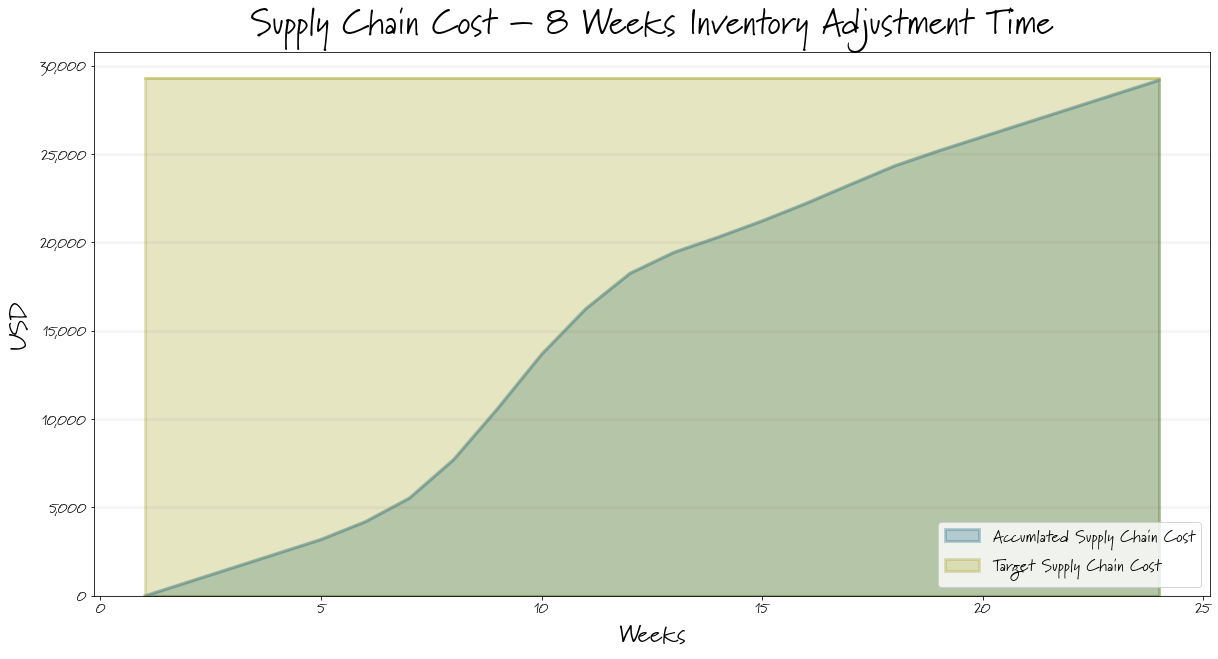

In [14]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["inventory_adjustment_time_8"],
    title="Supply Chain Cost – 8 Weeks Inventory Adjustment Time",
    x_label="Weeks",
    y_label="USD",
    equations=["performance_controlling.total_supply_chain_cost","policy_settings.target_supply_chain_cost"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_8_performance_controlling.total_supply_chain_cost" : "Accumlated Supply Chain Cost",
        "sd_dsl_beergame_inventory_adjustment_time_8_policy_settings.target_supply_chain_cost": "Target Supply Chain Cost"
    }
)

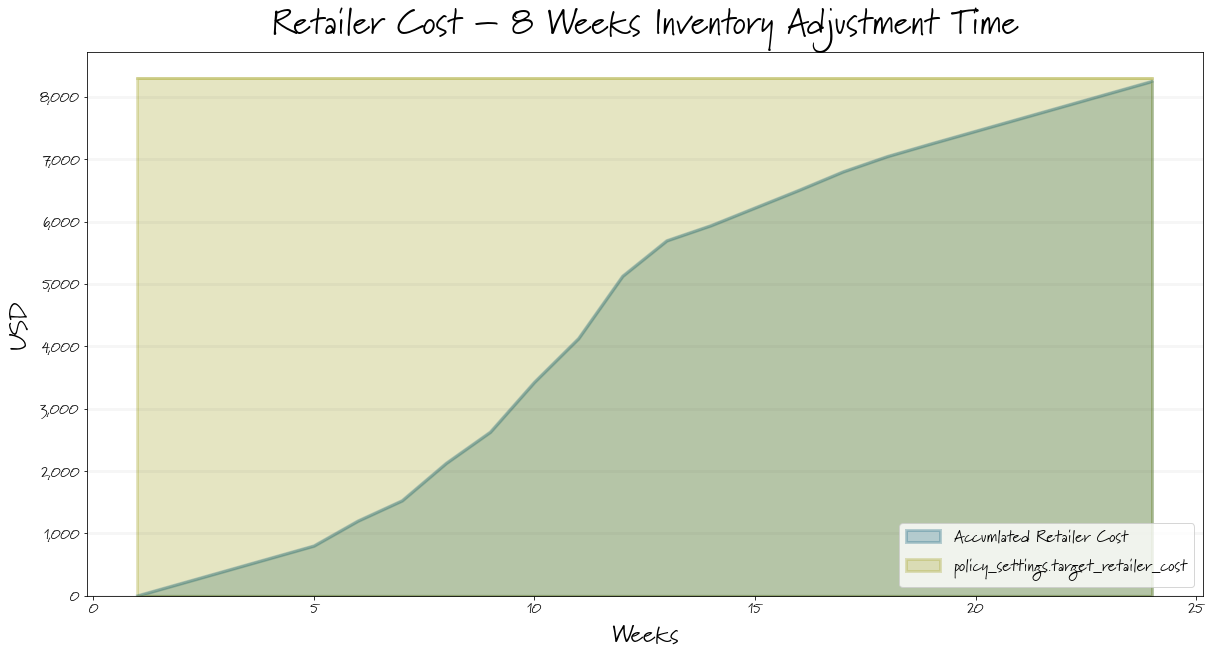

In [15]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["inventory_adjustment_time_8"],
    title="Retailer Cost – 8 Weeks Inventory Adjustment Time",
    x_label="Weeks",
    y_label="USD",
    equations=["performance_controlling.total_retailer_cost","policy_settings.target_retailer_cost"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_8_performance_controlling.total_retailer_cost" : "Accumlated Retailer Cost",
        "sd_dsl_beergame_inventory_adjustment_time_8_line_policy_settings.target_retailer_cost": "Target Retailer Cost"
    }
)

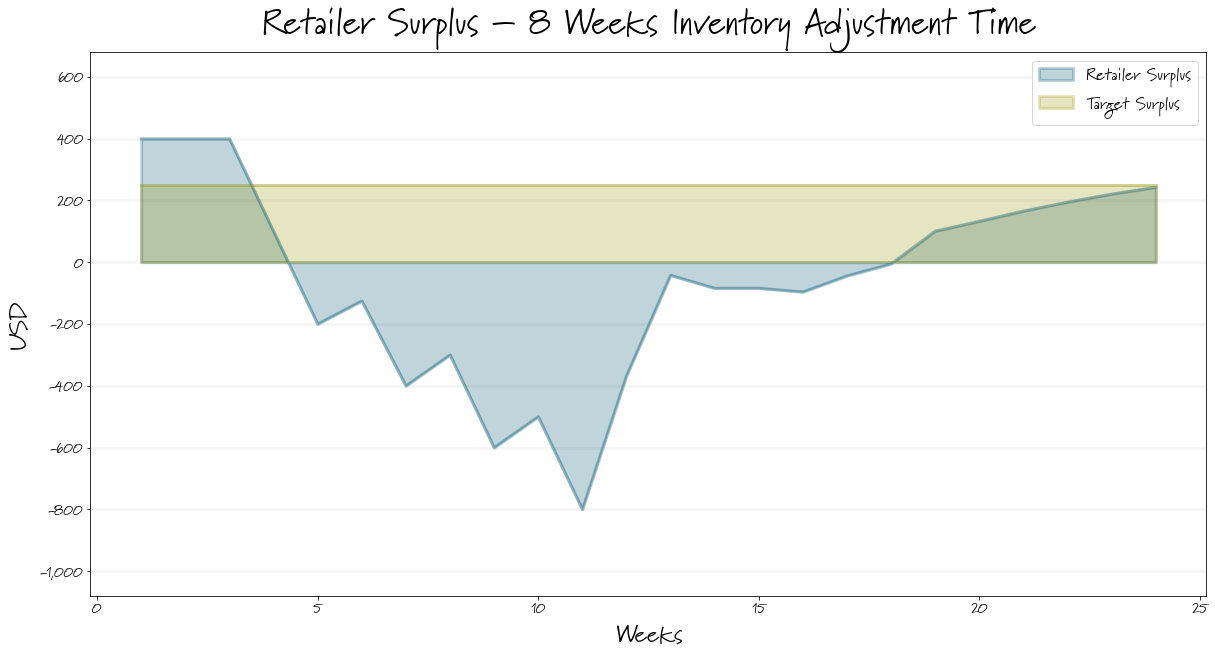

In [16]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
     scenarios=["inventory_adjustment_time_8"],
    title="Retailer Surplus – 8 Weeks Inventory Adjustment Time",
    x_label="Weeks",
    y_label="USD",
    equations=["retailer.surplus","policy_settings.target_surplus"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_8_retailer.surplus" : "Retailer Surplus",
        "sd_dsl_beergame_inventory_adjustment_time_8_policy_settings.target_surplus": "Target Surplus"
    }
)

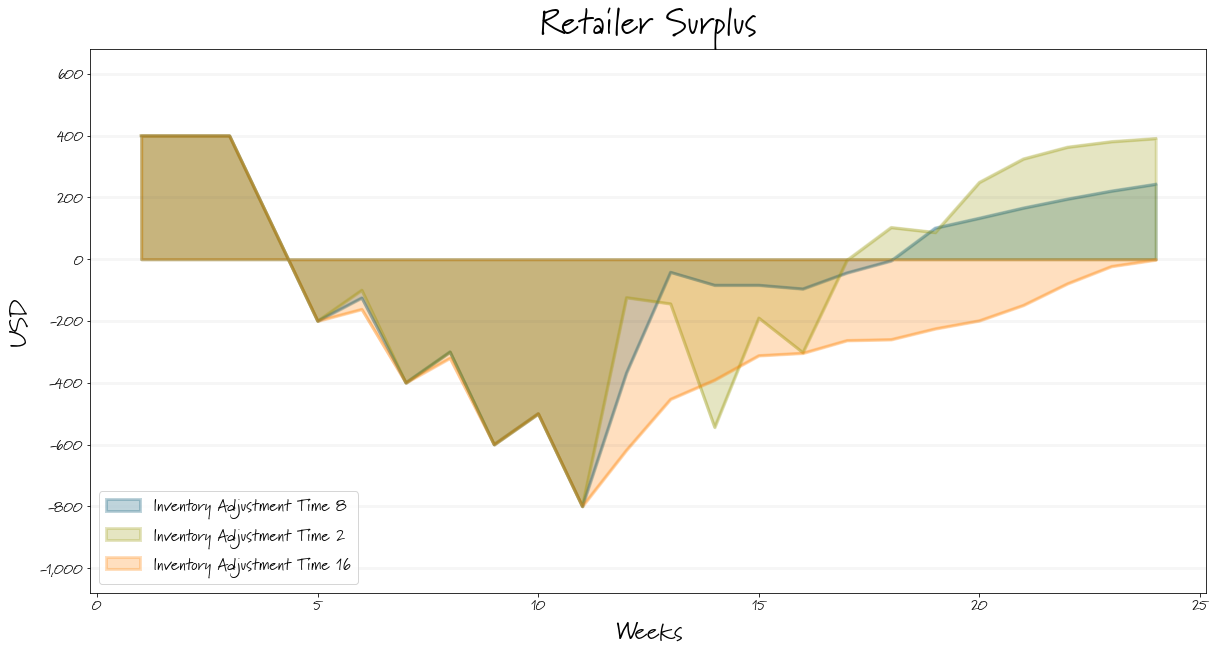

In [17]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
     scenarios=["inventory_adjustment_time_2","inventory_adjustment_time_8","inventory_adjustment_time_16"],
    title="Retailer Surplus",
    x_label="Weeks",
    y_label="USD",
    equations=["retailer.surplus"],
    series_names={
          "sd_dsl_beergame_inventory_adjustment_time_2_retailer.surplus" : "Inventory Adjustment Time 2",
        "sd_dsl_beergame_inventory_adjustment_time_8_retailer.surplus" : "Inventory Adjustment Time 8",
        "sd_dsl_beergame_inventory_adjustment_time_16_retailer.surplus": "Inventory Adjustment Time 16"
    }
)

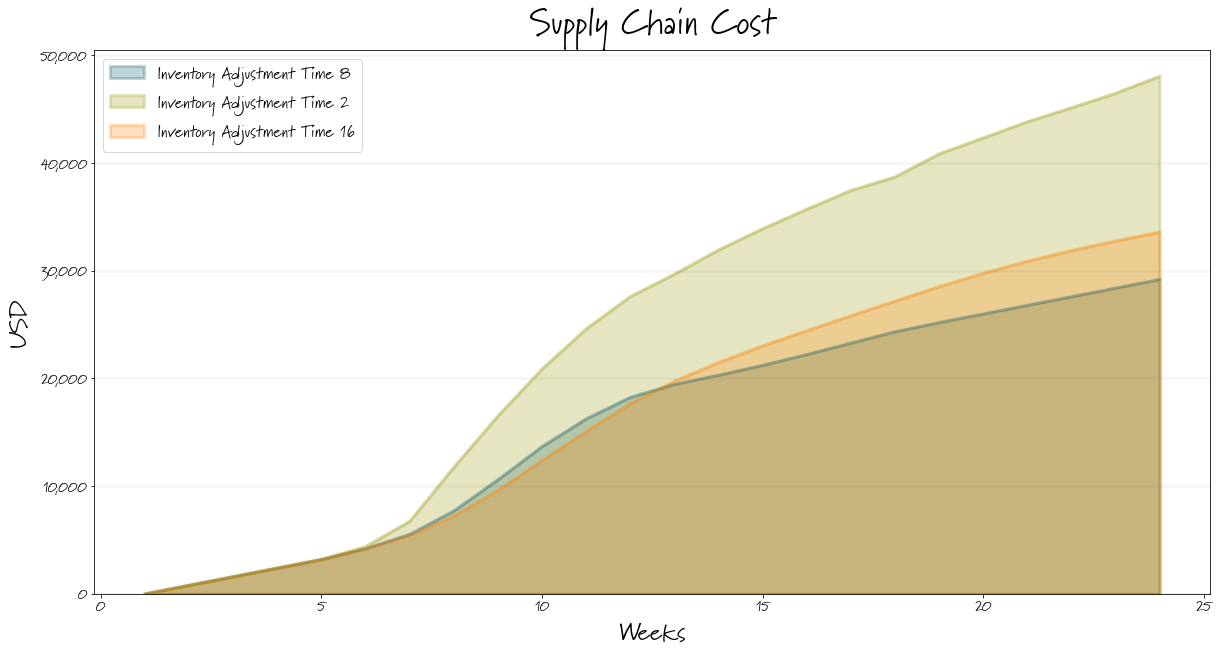

In [18]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["inventory_adjustment_time_8","inventory_adjustment_time_2","inventory_adjustment_time_16"],
    title="Supply Chain Cost",
    x_label="Weeks",
    y_label="USD",
    equations=["performance_controlling.total_supply_chain_cost"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_2_performance_controlling.total_supply_chain_cost" : "Inventory Adjustment Time 2",
        "sd_dsl_beergame_inventory_adjustment_time_8_performance_controlling.total_supply_chain_cost" : "Inventory Adjustment Time 8",
        "sd_dsl_beergame_inventory_adjustment_time_16_performance_controlling.total_supply_chain_cost": "Inventory Adjustment Time 16"
    }
)